In [9]:
from sklearn.model_selection import train_test_split
from models.DCNN import DCNN
import librosa
import numpy as np
from torchinfo import summary
from torch import nn
from torch.optim import Adam
from Utils import read_data,create_dataloader, k_fold_cross_validation, train, test
import matplotlib.pyplot as plt

# Read Data

In [10]:
sr = 16 * 1000
x,y,min_length = read_data(root='../Data/genres_original', sr=sr)
print("finsh reading data")

finsh reading data


# Segment and Normalise 

In [11]:
for i in range(len(x)):
    x[i] = x[i][0:min_length]
    x[i] = librosa.util.normalize(x[i])
x = np.asarray(x)
y = np.asarray(y)
seg_length = 59049 # segment length must be 59049
frame_num = int(x.shape[1]/seg_length)
x = x[:, :frame_num*seg_length].reshape(frame_num*x.shape[0],1,seg_length)
y = (y.reshape(y.shape[0],1)*np.ones((y.shape[0],frame_num))).reshape(y.shape[0]*frame_num)
print("finish segmentation and normalisation")

finish segmentation and normalisation


# Split Data 

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    stratify=y,shuffle=True)
# k-fold cross validation
k = 5
xs_train, ys_train, xs_valid, ys_valid = k_fold_cross_validation(x_train,y_train,k)
print("finish splitting data")

finish splitting data


# Create Dataloaders

In [13]:
batch_size = 64
dataloaders_train = []
dataloaders_valid = []
for i in range(k):
    dataloaders_train.append(create_dataloader(xs_train[i], ys_train[i], batch_size=batch_size))
    dataloaders_valid.append(create_dataloader(xs_valid[i], ys_valid[i], batch_size=batch_size))
dataloader_test = create_dataloader(x_test, y_test, batch_size=batch_size)
print("finish creating dataloaders")

finish creating dataloaders


# Model Construction

In [14]:
model = DCNN(10)
model.cuda()
loss_function = nn.CrossEntropyLoss()
opt = Adam(model.parameters(), lr=0.001)
summary(model,[(batch_size,1,seg_length)])

Layer (type:depth-idx)                   Output Shape              Param #
DCNN                                     [64, 10]                  --
├─ConLayer: 1-1                          [64, 128, 19683]          --
│    └─Conv1d: 2-1                       [64, 128, 19683]          512
│    └─BatchNorm1d: 2-2                  [64, 128, 19683]          256
│    └─ReLU: 2-3                         [64, 128, 19683]          --
├─Sequential: 1-2                        [64, 128, 2187]           --
│    └─ConLayer: 2-4                     [64, 128, 6561]           --
│    │    └─Conv1d: 3-1                  [64, 128, 19683]          49,280
│    │    └─BatchNorm1d: 3-2             [64, 128, 19683]          256
│    │    └─ReLU: 3-3                    [64, 128, 19683]          --
│    │    └─MaxPool1d: 3-4               [64, 128, 6561]           --
│    └─ConLayer: 2-5                     [64, 128, 2187]           --
│    │    └─Conv1d: 3-5                  [64, 128, 6561]           49,280
│   

# Train

In [15]:
epoch = 10
history = train(model,loss_function,opt,dataloaders_train,dataloaders_valid,k,epoch=epoch)
print("finish training")

-------epoch  1 -------
fold 1:
train set loss: 2.0730071023106573
train set accuracy: 0.44511720538139343
valid set loss: 1.9938128650188447
valid set accuracy: 0.557812511920929
fold 2:
train set loss: 1.978340095281601
train set accuracy: 0.610546886920929
valid set loss: 1.9609238743782043
valid set accuracy: 0.625
fold 3:
train set loss: 1.9311869323253632
train set accuracy: 0.6957031488418579
valid set loss: 1.9656750202178954
valid set accuracy: 0.5679687857627869
fold 4:
train set loss: 1.8976799741387367
train set accuracy: 0.7289062738418579
valid set loss: 1.901911187171936
valid set accuracy: 0.6664062738418579
fold 5:
train set loss: 1.858638896048069
train set accuracy: 0.781054675579071
valid set loss: 1.9485240399837493
valid set accuracy: 0.5609375238418579
epoch loss: 1.954
epoch accuracy: 0.596
-------epoch  2 -------
fold 1:
train set loss: 1.8289418399333954
train set accuracy: 0.808398425579071
valid set loss: 1.9036247432231903
valid set accuracy: 0.600000023841

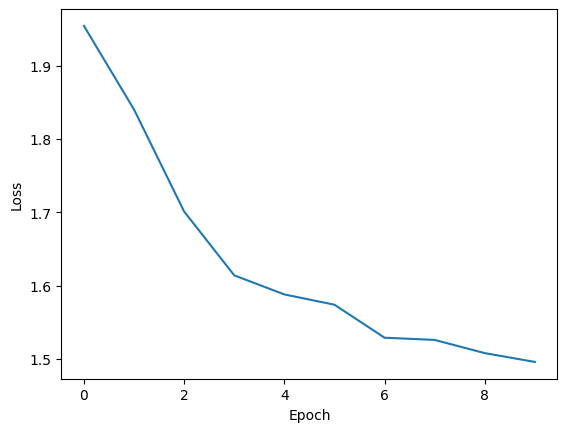

In [16]:
plt.plot(range(epoch),history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

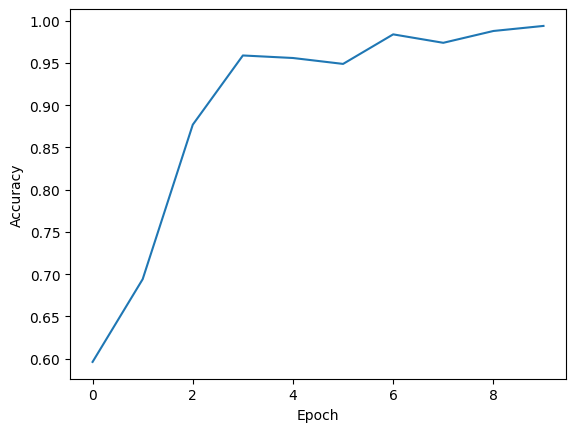

In [17]:
plt.show()
plt.plot(range(epoch), history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Test

In [18]:
loss, acc, AUC, f1 = test(model,loss_function,dataloader_test)

test set loss: 1.602
test set accuracy: 0.879
test set AUC: 0.985
test set f1-score: 0.879


(1.602, 0.879, 0.985, 0.879)